# Supervised Learning
## By Yosry Negm

<br><hr><br>
In this project, I will use several supervised learning algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. Then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. As in the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data investigated here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
The code below will load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [7]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import warnings
#warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
warnings.filterwarnings("ignore")
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
from sklearn.metrics import f1_score, accuracy_score

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. The code below will compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [8]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data.income==">50K"])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data.income=="<=50K"])

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k/n_records*100.0

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

The code below plots a histogram of these two features. Note the range of the values present and how they are distributed.

In [9]:
def distribution(data, transformed = False):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    # Create figure
    fig = pl.figure(figsize = (11,5));

    # Skewed feature plotting
    for i, feature in enumerate(['capital-gain','capital-loss']):
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000))
        ax.set_yticks([0, 500, 1000, 1500, 2000])
        ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()


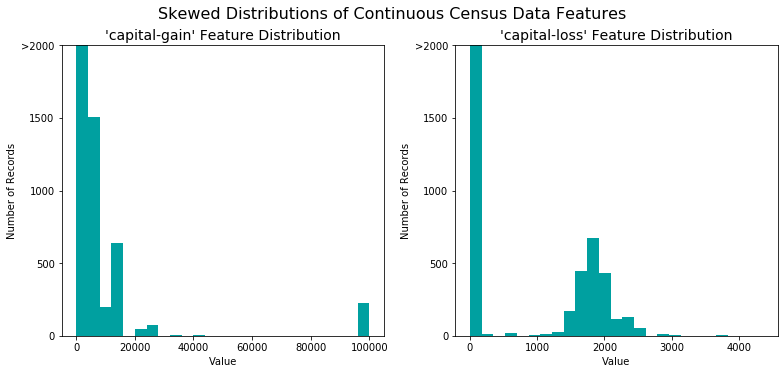

In [10]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)
# Visualize skewed continuous features of original data
distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

The code below performs a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

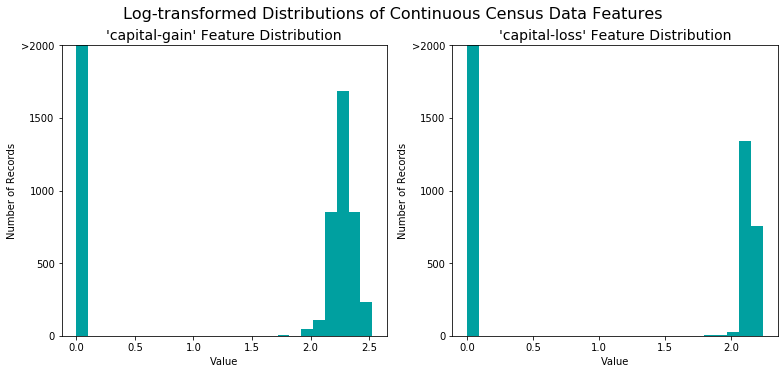

In [12]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

The code below will normalize each numerical feature. I will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [13]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.855471,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code below, we will implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [14]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.replace({'<=50K':0, '>50K':1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

The code below performs this split.

In [17]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, I will investigate four different algorithms, and determine which is best at modeling the data. 

### Metrics and the Naive Predictor

We assume that our imaginary charity non-profit organization, equipped with their research knows individuals that make more than \$50,000 are most likely to donate to their charity. 
Let us also suppose that our virtual organization is particularly interested in predicting who makes more than *$50,000* accurately. It would seem that using <font color=green>accuracy</font> as a metric for evaluating a particular model's performace would be appropriate. 


Additionally, identifying someone that does not make more than*$50,000* as someone who does would be detrimental to our imaginary charity non-profit organization, since they are looking to find individuals willing to donate.

 Therefore, a model's ability to precisely predict those that make more than *$50,000* is *more important* than the model's ability to **recall** those individuals. We can use <font color=green>F-beta score</font> as a metric that considers both <font color=green>precision</font> and <font color=green>recall</font>:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes ( those who make at most *$50,000*, and those who make more), it's clear most individuals do not make more than \$50,000.

 This can greatly affect <font color=green>accuracy</font>, since we could simply say "this person does not make more than \$50,000" and generally be right, without ever looking at the data! Making such a statement would be called <font color=green>naive</font>, since we have not considered any information to substantiate the claim. It is always important to consider the <font color=green>naive prediction</font> for our data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than $50,000, imaginary charity non-profit organization would identify no one as donors.

#### Note: Recap of accuracy, precision, recall

** <font color=green>Accuracy</font> ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** <font color=green>Precision</font> ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** <font color=green>Recall (sensitivity)</font> ** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? The code below assigns values to `'accuracy'` and `'fscore'` to be used later.

** note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally our base model would be either the results of a previous model or could be based on a research paper upon which we are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place we could start from.

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [18]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# Calculate accuracy, precision and recall
TP = np.sum(income)  
FP = income.count() - TP
TN = 0
FN = 0
accuracy =float(TP)/(TP+FP)
recall =float(TP)/(TP+FN)
precision = TP / (TP + FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.

fscore = (1+0.5**2)*(precision*recall)/(0.5**2*precision+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Model Application

**after investigating the underlying data in this project and trying to figure out the suitable model to fullfill the requirements asked by our charity non-profit organization I could propose that the following three algorithms may be good candidates to build the required model:-**

## (A) Logistic Regression :
- Most common algorithm which could be used as binary classifier in a variety of real world applications such as detecting wether a patient is subject to lung cancer or not based on some information from his medical records. Also, could be used to predict heart attack (expected or not ) based on the patient's medical history. refer to [this link](https://hub.packtpub.com/healthcare-analytics-logistic-regression-to-reduce-patient-readmissions/) and [this](http://www.iaeng.org/IJAM/issues_v40/issue_2/IJAM_40_2_08.pdf) for a practical medical application to logistic regression.  
- Its strength resides in being <b>straightforward</b> to understand and explain,<b>can be regularized to avoid overfitting</b> nd its tendency to give <b>calibrated predictions</b>. Also,because the gradient is sparse (or has a sparse approximation in the regularized case), it is a good fit for domains with sparse features such we are using as well as it has Outputs which give a <b>nice probabilistic interpretation</b> 
- one of the weakness of the logistic regression algorithm is its tendency to perform poorly when there are<b> multiple</b> or <b>nonlinear decision boundaries</b>.it is not flexible enough to naturally capture more<b>complex relationships</b>. check [this link](http://www.academicstar.us/UploadFile/Picture/2014-6/201461494819669.pdf) for more info.
- Reasons for nominate logistic regression to model our problem are that we have clean data and we require binary classification to be performed on it as well as it could give reasonable response in a reasonable time.

## (B) Ensemble Methods - AdaBoost  :
- as a real life example of using ensemble methods is to use AdaBoost algorithm to analyze basketball game i.e. to recognize face and body parts for player detection during basketball games on a video footage obtained from the single moving camera. ([check this link](https://www.uni-obuda.hu/journal/Markoski_Ivankovic_Ratgeber_Pecev_Glusac_57.pdf))  
- Its strength that it is <b>fast and very adaptive</b> classification algorithm and <b>less prone to overfitting</b>.It is  valid for ery complex decision boundaries.
- its weaknesse is that it is slow in training and tends to be sensitive for noisy data and outliers.
- Reasons for suggesting this algorithm for the current problem are that our dataset is clean and contains 45222 data points and this could be considered reaonable for that algorithm if we not considered the long training time and slowness.

## (C) Decision Trees :
- Decision tree algorithm could be used in IT security Intrusion Detection system (<b>IDS</b>) that monitors a network for malicious activities or policy violations. ([check this link](https://www.researchgate.net/publication/312296143_AN_APPLICATION_OF_DECISION_TREES_IN_INTRUSION_DETECTION))  
- Its strength that it is able to handle <b>categorical and numerical</b> data, help <b>avoiding irrelevant features</b> by using information gain,fairly robust to outliers,Doesn’t require much data pre-processing,can handle data which hasn’t been normalized ,reduce time complexity and could be utilized in nonlinear relationships. In addition, it is Easy to use ,interpret and visualise the decision boundary.
- its weaknesses are that it is prone to overfitting if there are too many features (they can keep branching until they memorize the training data) or is prone to underfitting if there is too little data ,hence complex decision trees do not generalize well.Also it is unstable, as small variations in the data can result in a different decision tree.as well as it can create biased trees if some classes dominate.
- Reason for being candidate for our problem is to make the process fast since decision tree doesn't require specific domain knowledge.

### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model I've chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. our implementation here will be used in the following section.
In the code block below, we will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [21]:
# Import two metrics from sklearn - fbeta_score and accuracy_score

from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
 

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    
    results['pred_time'] = end-start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
   
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
        
    # Compute F-score on the test set which is y_test
    
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Initial Model Evaluation
In the code below, we are implementing the following:
- Import the three supervised learning models I've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

In [22]:
def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = pl.subplots(2, 3, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    pl.tight_layout()
    pl.show()
    

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.


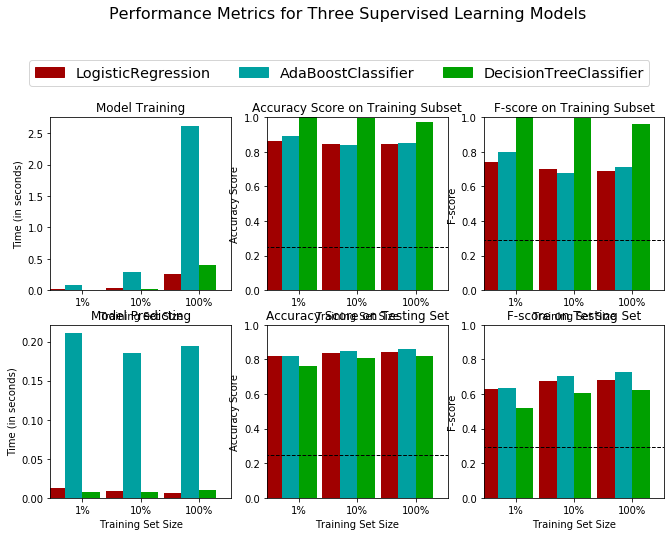

In [23]:
# Import the three supervised learning models from sklearn

from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


# Initialize the three models

clf_A = LogisticRegression(random_state=1) # Logisitic Regression Classifier
clf_B = AdaBoostClassifier(random_state=1) # Support Vector Machines Classifier
clf_C = DecisionTreeClassifier(random_state=1) # Decision Tree Classifier

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# metrics visualization for the three supervised learning models chosen
evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, we will choose from the three supervised learning models the *best* model to use on the data. we will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Choosing the Best Model

From our initial model evaluation and based on the resulting performance metrics for the three proposed learning models and inspecting the used dataset ,I could conclude that using <font color='green'><b>Logistic regression</b></font> is the right choice in our case because when using 100% of the training set (in the testing phase) it gives robust performance indicated by the <b>high accuracy</b> (about 0.84 ) and <b>moderate F-Score</b> (about 0.68) as well as its <b>resonable prediction</b> compared to the other two algorithms .Note, it looksthat AdBoost performs better but it takes long time to respond than others but since the diffierence in accuarcy and performance between it and logistic regression on this model is negliable we could ignore it and depend on logistic regression to get best results.

### Describing the Model in Layman's Terms

we will use the <font color='green'><b>Logistic Regression</font></b> algorithm which is a <b>classification</b> algorithm for analyzing a dataset in which there are one or more nominal, ordinal, interval or ratio-level independent variables(<b>Features</b>) that determine an outcome which in turn is a <b>binary dependent variable</b> which has two possible values(can be generalized to more i.e. is categorical),often labelled as "0" and "1" to represent outcomes such as pass/fail, win/lose, alive/dead or healthy/sick and specifically, in our case <u> "More than 50k Dollars" or not </u> or in other words <b> "may Donate" or may not" </b> .You can think of logistic regression as a special case of linear regression when the outcome  variable is <i>categorical</i>, where we are <b>predicting the probability</b> of occurrence of an event by fitting data to a certain function i.e. To predict which class a data belongs,a threshold can be set. Based upon this threshold,the obtained estimated probability is classified into classes.Say, if predicted_value ≥ 50k dollars,then classify "May Donate" else "may not ". Decision boundary can be linear or nonlinear(Polynomial order can be increased to get complex decision boundary). We could accomplish this by using a mathematical function called the logistic function(sigmoid function), it can take any real-valued number and map it into a value between 0 and 1.Making predictions with a logistic regression model is as simple
as inputting in numbers into the logistic regression function and calculating a result.

### Model Tuning
Now I will fine tune the chosen model using grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. I will use the entire training set for this. In the code below, I implemented the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [24]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = LogisticRegression(random_state=1)

# Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}

parameters ={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}


# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid = parameters,scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8413
F-score on testing data: 0.6817

Optimized Model
------
Final accuracy score on the testing data: 0.8406
Final F-score on the testing data: 0.6807


### Final Model Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.8419      |     0.8420      |
| F-score        |       0.6832      |     0.6842      |


From the above result we could note that the <b><font color='green'>optimized</font></b> values of Accuracy (<b><font color='green'>0.8420</font></b>) and F-score (<b><font color='green'>0.6842</font></b>) for our selected model is<b> enhanced</b> a little bit and it is <b>better</b> than the <b><font color='red'>unoptimized</font></b> model's values of Accuracy (<b><font color='red'>0.8419</font></b>) and F-score (<b><font color='red'>0.6832</font></b>).Also we could note that they are <b><font color='blue'>greatly imporoved</font></b> compared to the Naive Byes Classifer used in Question 1 (benchmark predictor) which were Accuracy (<b><font color='blue'>0.2478</font></b>) and F-score (<b><font color='blue'>0.2917</font></b>),we could conclude from that:<i>it is useful to always optimize your model</i>.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

I've Chosen a scikit-learn classifier that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next code  fiting this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Feature Relevance Observation

After looking back at data exploration section, I think the most significant five feature for our model prediction are <b>in order</b> as following :-
1. <b>Education</b> : we could think about well educated person may have good income that allow him to donate and also he more aware of the importance of donation rather than less educated one.
2. <b>Capital Gain</b> : this reflects his profit and hence the income ,if it is high this may encourage the person to donate freely.
3. <b>Capital Loss</b> : this feature representing a financial issues which may lead to lower income and block the person from donation. 
4. <b>Occupation</b> : Notably the income is depending on the persons field of work and hence his ability to donate either by plenty of money or the culture related to his work environment.
5. <b>Age</b> : I think Mature people tends to donate more than younger ones ,the are wise and have enough experience to valuate the importance of donation.  

### Extracting Feature Importance
Using a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code below, I will implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

In [25]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = pl.figure(figsize = (9,5))
    pl.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    pl.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    pl.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    pl.xticks(np.arange(5), columns)
    pl.xlim((-0.5, 4.5))
    pl.ylabel("Weight", fontsize = 12)
    pl.xlabel("Feature", fontsize = 12)
    
    pl.legend(loc = 'upper center')
    pl.tight_layout()
    pl.show()  


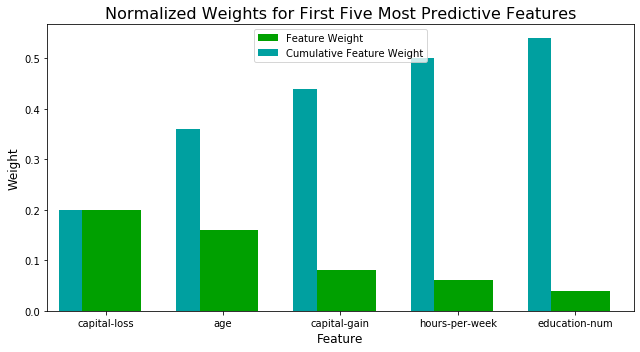

In [26]:
# Import a supervised learning model that has 'feature_importances_'

clf = AdaBoostClassifier(random_state=1)

# Train the supervised model on the training set using .fit(X_train, y_train)
model = clf.fit(X_train,y_train)

# Extract the feature importances using .feature_importances_ 
importances = clf.feature_importances_

# Plot
feature_plot(importances, X_train, y_train)

### Extracting Feature Importance

Observing the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
I've missed <b>only</b> the "hours-per-week" in place of "Capital-Gain" and I think they are related some how and have the same effect i.e as "hours-per-week" increases this means more work that leads to more "Capital gain" and hence more  income and vice versa, so they are equal in importance and one of them enough.
<b>Another difference</b> in my answer is the rank of feature "Age" ,I put it at last but the visualization put it before last,and again in my point of view "Age" is less effective on donation tendency than Capital Loss/Gain but "Age" of course affects income (here's the point). <b>the remaining features and ranking I've made the same as the algorithm had made</b>.It Looks like that the algoritms was matching my thinking in somehow.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code below uses the same optimized model we found earlier, and train it on the same training set *with only the top five important features*. 

In [27]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8406
F-score on testing data: 0.6807

Final Model trained on reduced data
------
Accuracy on testing data: 0.8022
F-score on testing data: 0.5762


### Effects of Feature Selection

It appears that reducing No. of features will in turn reduce the performance of the model.As we noted that the Accuracy and F-score values of the reduced features is less than when the model including all the features and I propose that we should work on the entire features set unless we are working in quick response applications in which training time is more important than accuracy.Here I think this less important features reduction will also affect on the ability of the model to generalize well and if performance doesn't matter we could proceed with that otherwise no.Finally, we could say it is a Time/Space Trade-Off.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.